# Positive vs. Negative Sentiment Classification

Here we demonstrate how to explain a sentiment classification model for movie reviews. positive vs. negative sentim

In [47]:
import transformers
import datasets
import shap
import numpy as np

## Load the IMDB movie review dataset

In [2]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


## Load and run a sentiment analysis pipeline

In [3]:
classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
classifier(short_data[:2])

[[{'label': 'NEGATIVE', 'score': 0.0012035118415951729},
  {'label': 'POSITIVE', 'score': 0.9987965226173401}],
 [{'label': 'NEGATIVE', 'score': 0.002218781039118767},
  {'label': 'POSITIVE', 'score': 0.9977812170982361}]]

## Explain the sentiment analysis pipeline

In [4]:
# define the explainer
explainer = shap.Explainer(classifier)

In [5]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

In [6]:
shap.plots.text(shap_values[:,:,"POSITIVE"])

## Wrap the pipeline manually

SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces so we transform the probabilities into logit values (information values instead of probabilites).

### Create a TransformersPipeline wrapper

In [7]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False)

In [8]:
pmodel(short_data[:2])

array([[0.00120351, 0.99879652],
       [0.00221878, 0.99778122]])

In [9]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])

array([[-6.72130722,  6.72133589],
       [-6.10857607,  6.10857523]])

In [13]:
explainer2 = shap.Explainer(pmodel)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

### Pass a tokenizer as the masker object

In [15]:
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

### Build a Text masker explicitly

In [35]:
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

## Explore how the Text masker works

In [42]:
masker.shape("I like this movie.")

(1, 7)

In [48]:
model_args = masker(np.array([True, True, True, True, True, True, True]), "I like this movie.")
model_args

(array(['i like this movie .'], dtype='<U19'),)

In [49]:
pmodel(*model_args)

array([[-8.90780458,  8.90742142]])

In [50]:
model_args = masker(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args

(array(['i [MASK] [MASK] movie .'], dtype='<U23'),)

In [51]:
pmodel(*model_args)

array([[-3.72092204,  3.72092316]])

In [52]:
masker2 = shap.maskers.Text(classifier.tokenizer, mask_token="...", collapse_mask_token=True)

In [53]:
model_args2 = masker2(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args2

(array(['i . . . movie .'], dtype='<U15'),)

In [54]:
pmodel(*model_args2)

array([[-3.20818664,  3.20818753]])

## Plot summary statistics and bar charts

In [55]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:20])

Partition explainer: 21it [00:11,  1.76it/s]                        


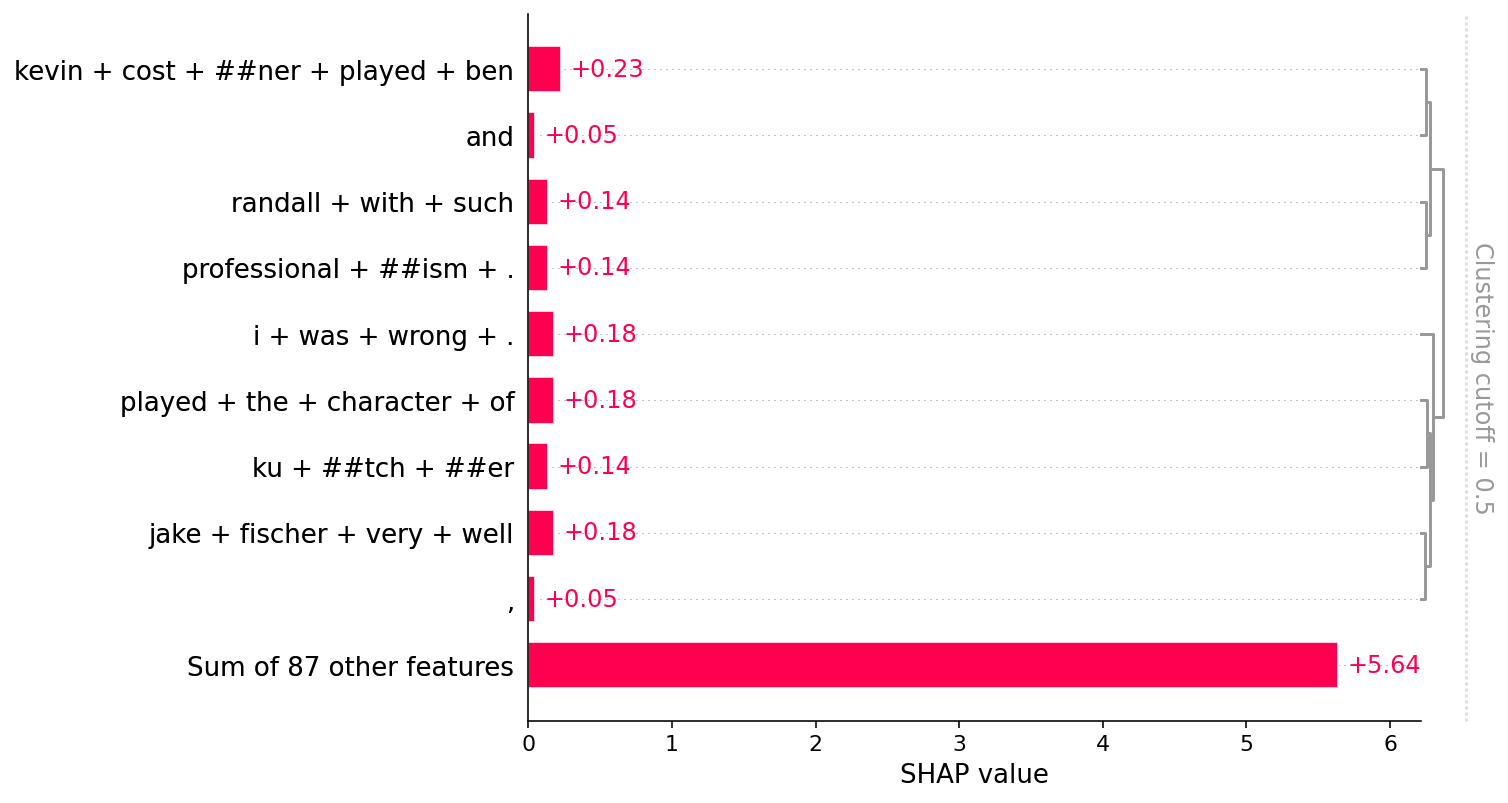

In [56]:
shap.plots.bar(shap_values[0,:,"POSITIVE"])

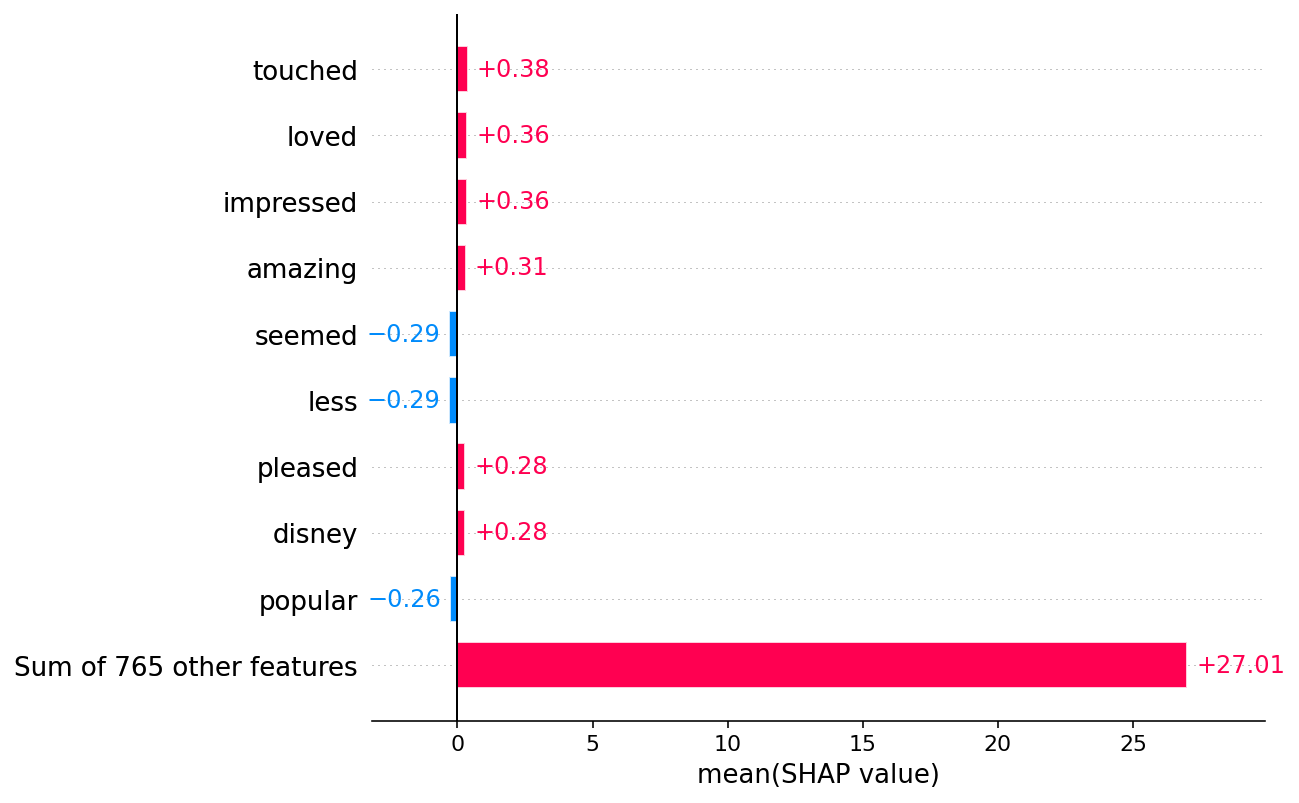

In [57]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))

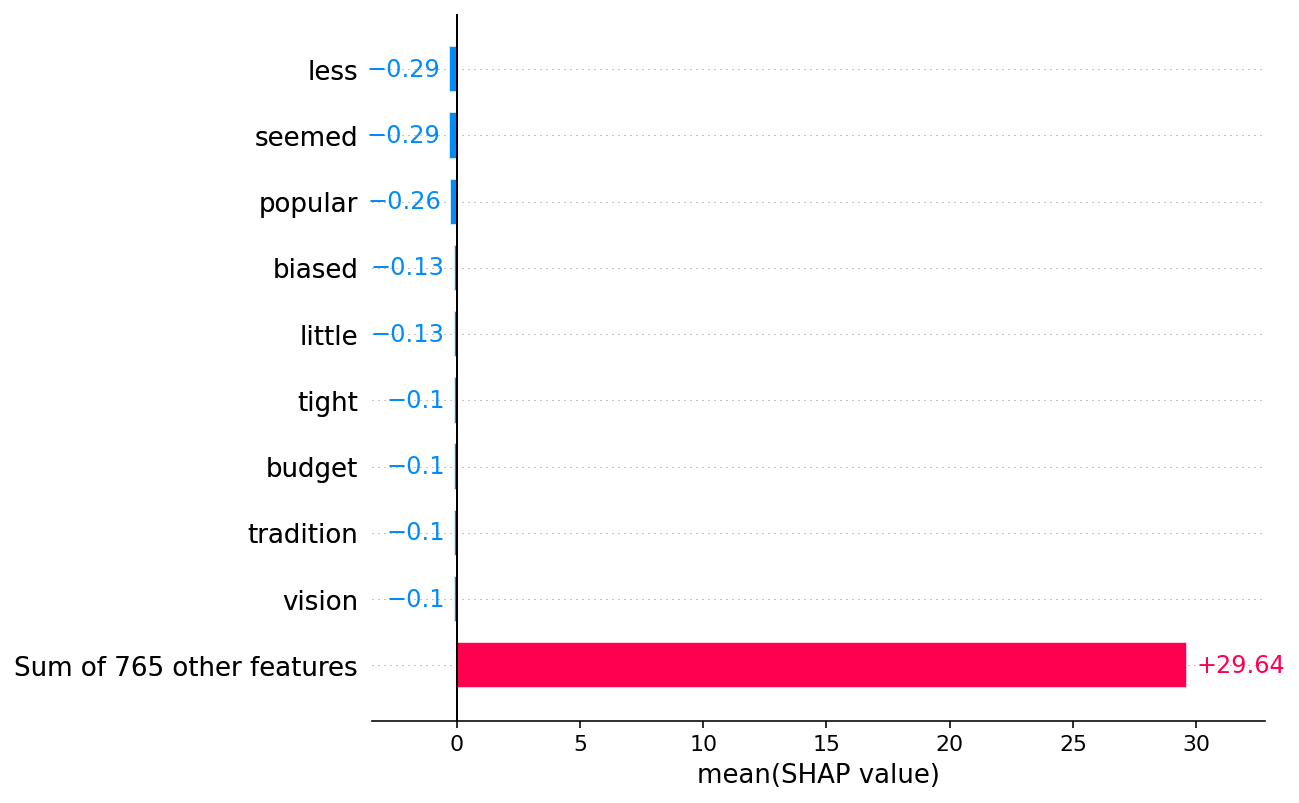

In [59]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)